In [1]:
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
import scanpy as sc
import scipy
from sklearn.decomposition import PCA

In [2]:
adata = ad.read_h5ad("/Users/apple/Desktop/KB/data/LarryData/Larry_41093_2000_norm_log.h5ad")
adata.shape

(41093, 2000)

##### Mean Variance plot

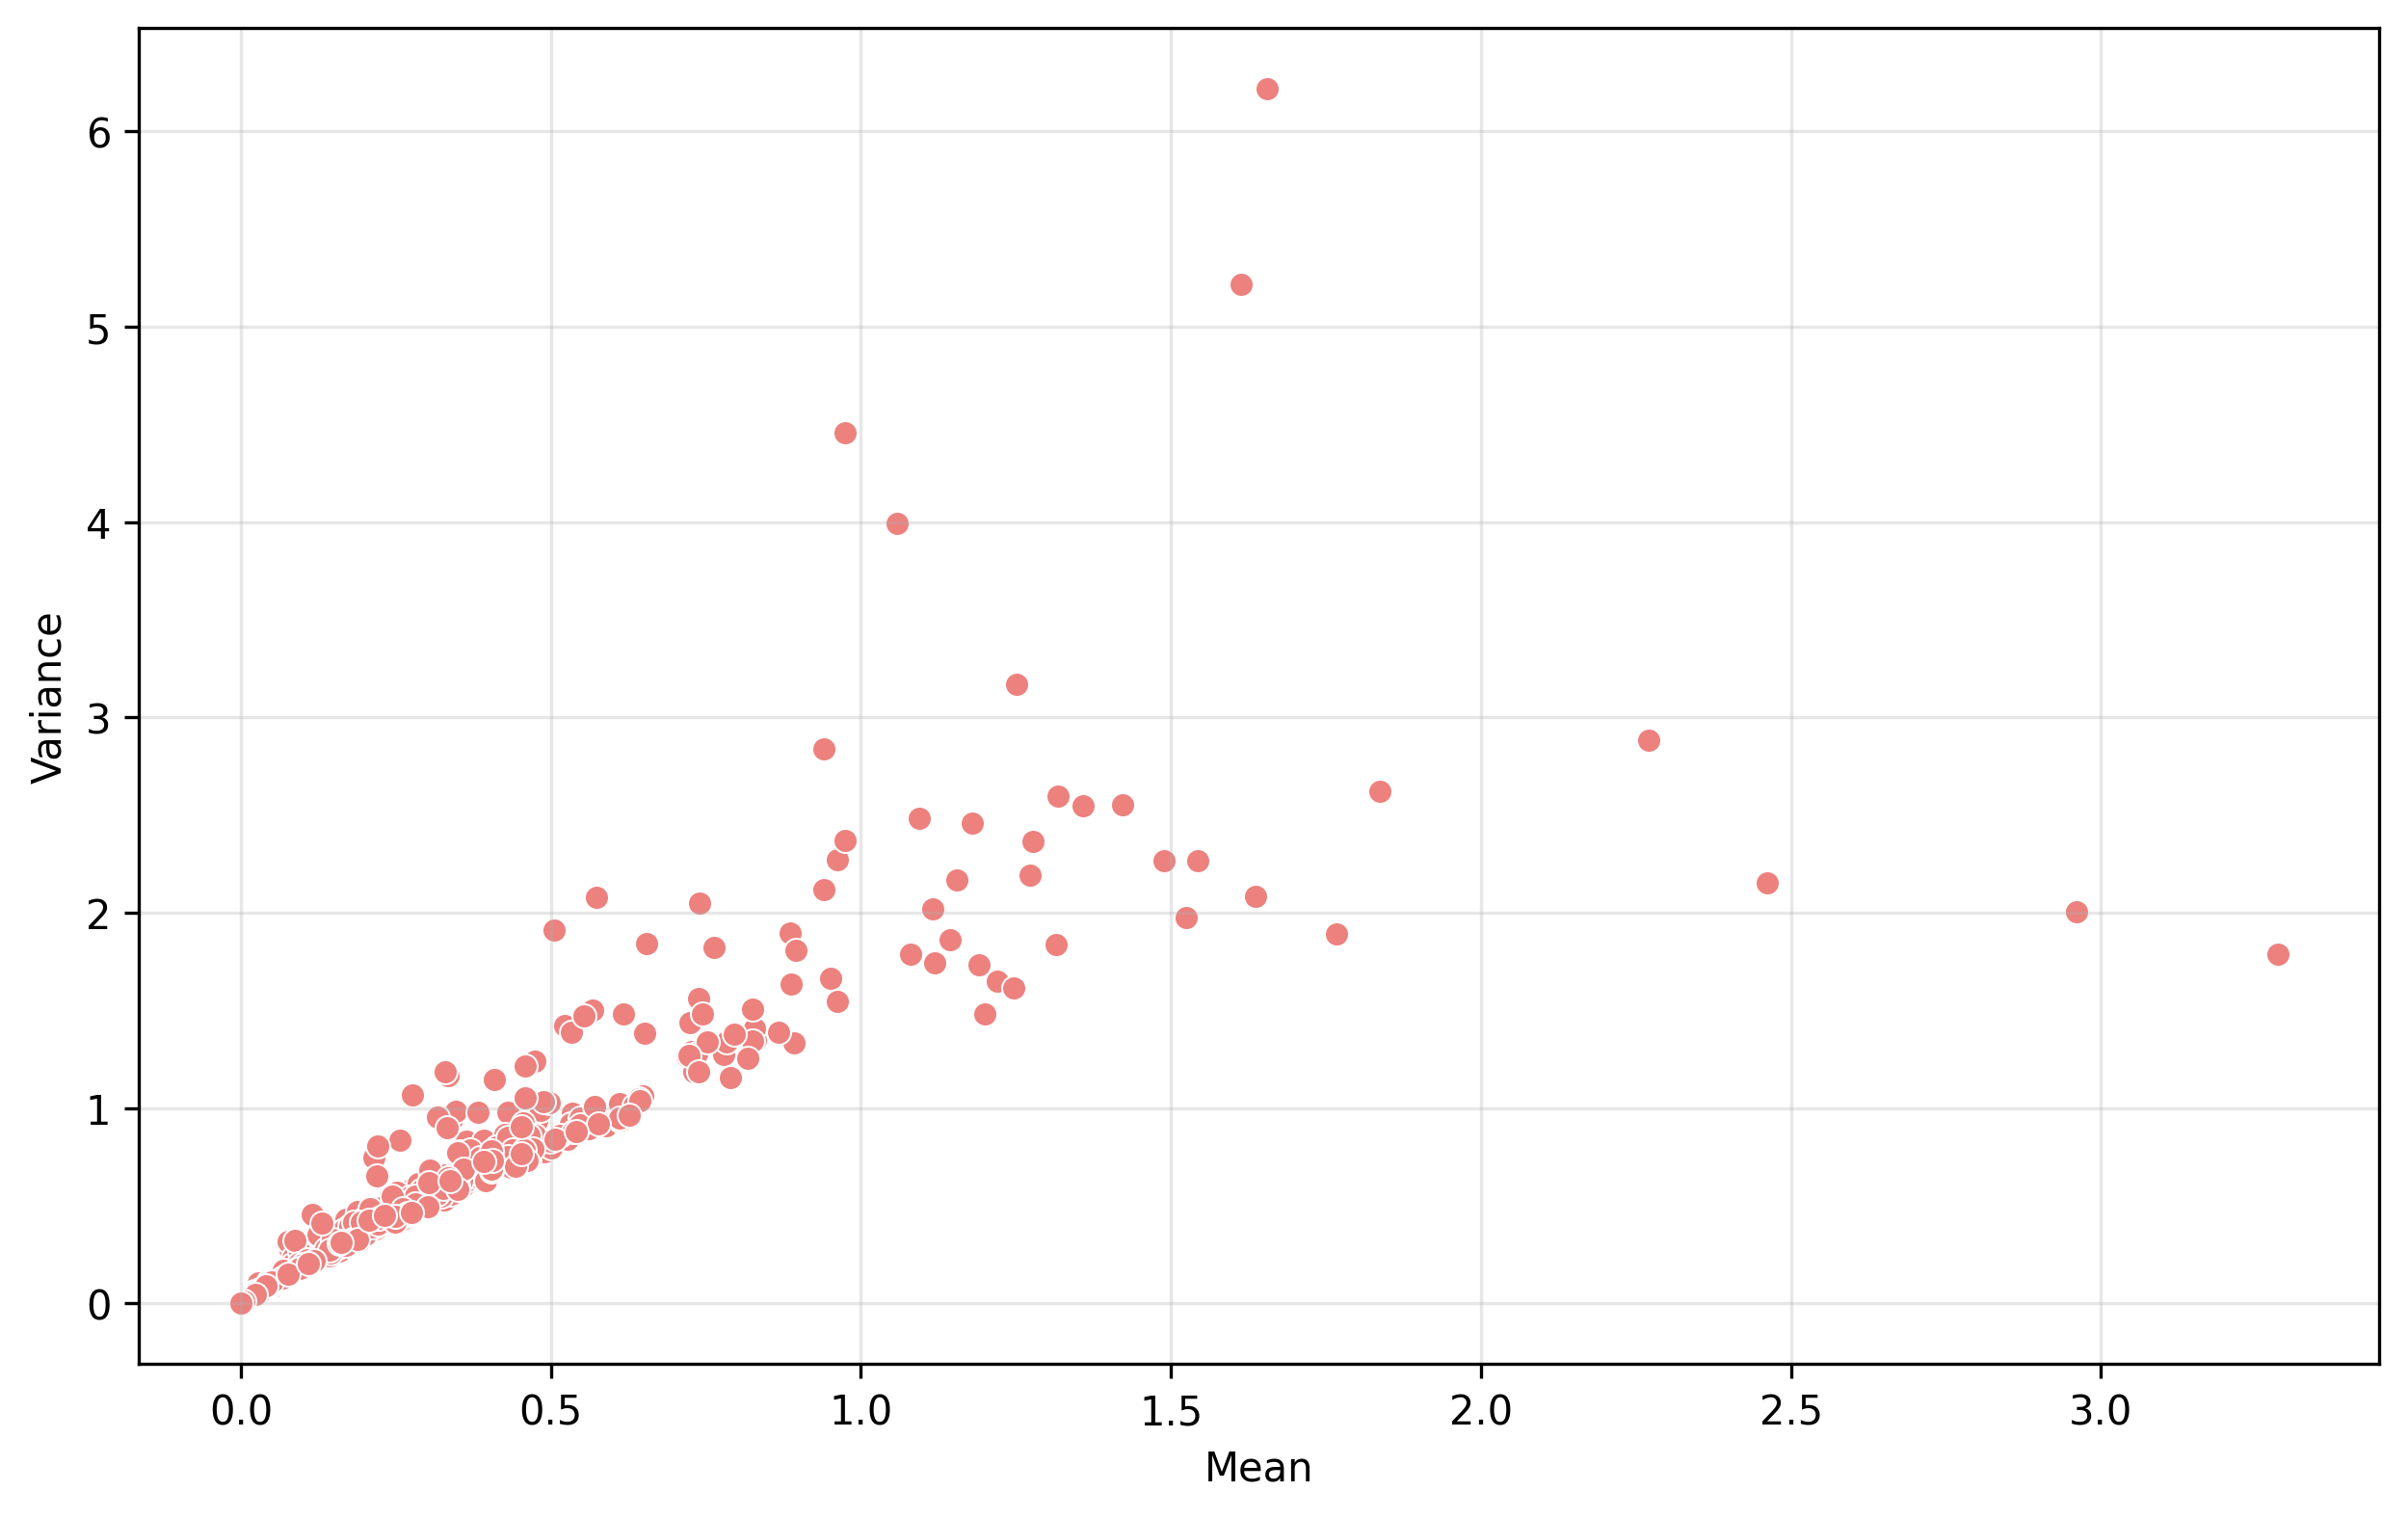

In [3]:
count_matrix = adata.X 
variances = np.var(count_matrix.toarray(), axis=0)
means = np.mean(count_matrix.toarray(), axis=0)
sorted_indices = np.argsort(-variances)
# Sort the variances in ascending order
# sorted_variances = np.sort(variances)

plt.figure(figsize=(10, 6), dpi=300)  # High resolution with 300 dpi
sns.scatterplot(x=means, y=variances, color='#EC817E')  # Using Seaborn for plotting
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.grid(True, alpha=0.3)  # Adding grid
plt.show()

In [4]:
import numpy as np

def calculate_average_variance_mean(adata, beta):
    """
    Calculate the average variance and average mean for the top beta*100% of genes
    based on variance.

    Parameters:
    adata: AnnData object
        The AnnData object containing the gene expression data.
    beta: float
        A value between 0 and 1 indicating the proportion of genes to consider.

    Returns:
    average_variance: float
        The average variance of the selected genes.
    average_mean: float
        The average mean of the selected genes.
    """
    # Ensure beta is within the valid range
    if beta < 0 or beta > 1:
        raise ValueError("Beta should be between 0 and 1.")

    # Calculate the number of genes to consider
    num_genes = int(beta * adata.X.shape[1])

    # Calculate the variances and means of all genes
    count_matrix = adata.X
    variances = np.var(count_matrix.toarray(), axis=0)
    means = np.mean(count_matrix.toarray(), axis=0)

    # Sort the indices by descending variance
    sorted_indices = np.argsort(-variances)

    # Select the top `num_genes` based on sorted variance
    selected_indices = sorted_indices[:num_genes]

    # Calculate the average variance and average mean for the selected genes
    average_variance = np.mean(variances[selected_indices])
    average_mean = np.mean(means[selected_indices])

    return average_variance, average_mean


In [5]:
ls_1 = [0.1, 0.3, 0.5, 0.7, 0.9]
for beta in ls_1:
    average_variance, average_mean = calculate_average_variance_mean(adata, beta)
    print(f"Average Variance for top {beta*100:.2f}% of genes: {average_variance}")
    print(f"Average Mean for top {beta*100:.2f}% of genes: {average_mean}")

Average Variance for top 10.00% of genes: 1.238621711730957
Average Mean for top 10.00% of genes: 0.670561671257019
Average Variance for top 30.00% of genes: 0.632554292678833
Average Mean for top 30.00% of genes: 0.340735524892807
Average Variance for top 50.00% of genes: 0.4081738293170929
Average Mean for top 50.00% of genes: 0.21884694695472717
Average Variance for top 70.00% of genes: 0.2947275638580322
Average Mean for top 70.00% of genes: 0.15793029963970184
Average Variance for top 90.00% of genes: 0.22969335317611694
Average Mean for top 90.00% of genes: 0.12306585162878036


In [6]:
ls_2 = [0.03, 0.05, 0.07, 0.09, 0.11]
for beta in ls_2:
    average_variance, average_mean = calculate_average_variance_mean(adata, beta)
    print(f"Average Variance for top {beta*100:.2f}% of genes: {average_variance}")
    print(f"Average Mean for top {beta*100:.2f}% of genes: {average_mean}")

Average Variance for top 3.00% of genes: 2.1345560550689697
Average Mean for top 3.00% of genes: 1.1576955318450928
Average Variance for top 5.00% of genes: 1.7263630628585815
Average Mean for top 5.00% of genes: 0.930766761302948
Average Variance for top 7.00% of genes: 1.4763915538787842
Average Mean for top 7.00% of genes: 0.796110987663269
Average Variance for top 9.00% of genes: 1.306288480758667
Average Mean for top 9.00% of genes: 0.7066740393638611
Average Variance for top 11.00% of genes: 1.1775918006896973
Average Mean for top 11.00% of genes: 0.6373929381370544


#### PCA and then Leiden cluster 

In [7]:
def simulation_data_generator(beta, resolution=16):

    adata = ad.read_h5ad("/Users/apple/Desktop/KB/data/LarryData/Larry_41093_2000_norm_log.h5ad")
    
    count_matrix = adata.X 
    variances = np.var(count_matrix.toarray(), axis=0)
    sorted_indices = np.argsort(-variances)

    # reorder the gene (columns) according to their variances in a descending order
    count_matrix_reordered = (count_matrix[:, sorted_indices]).toarray()

    # if np.max(variances)== np.var(count_matrix_reordered, axis=0)[0]:
    #     print("reorder process done")
    # else:
    #     print("reorder process went wrong")

    # only input first beta*num_genes gene into the K-means cluster
    matrix_for_cluster = count_matrix_reordered[:,:int(beta*count_matrix_reordered.shape[1])]

    # Perform PCA
    pca = PCA(n_components=50)
    pcax_result = pca.fit_transform(matrix_for_cluster)
    # Step 2: Convert the PCA result to an AnnData object to use Leiden clustering
    adata_pca = sc.AnnData(X=pcax_result)
    
    # Step 3: Build a nearest neighbor graph (required for Leiden clustering)
    sc.pp.neighbors(adata_pca, n_neighbors=10, use_rep='X')

    # Step 4: Perform Leiden clustering
    sc.tl.leiden(adata_pca, resolution=resolution)  # Adjust resolution as needed

    # Step 5: Map the Leiden cluster IDs to new clone IDs
    new_clone_ids = adata_pca.obs['leiden'].astype(int).to_numpy()

    # print("number of lineages generated: ", len(set(new_clone_ids)))
    
    # Step 6: Assign these new clone IDs back to your original AnnData object
    adata.obs['clone_id'] = new_clone_ids

    numcell_lin = adata.obs['clone_id'].value_counts()
    print("number of cells in a lineage info: ", "min: ", np.min(numcell_lin), "max: ", np.max(numcell_lin), "mean: ", np.mean(numcell_lin))

    # Count the frequency of each label
    label_counts = pd.Series(new_clone_ids).value_counts()
    # Identify labels that appear fewer than 5 times
    labels_to_keep = label_counts[label_counts >= 5].index

    # Filter out cells with labels that appear fewer than 5 times
    cells_to_keep = adata.obs['clone_id'].isin(labels_to_keep)
    filtered_adata = adata[cells_to_keep].copy()
    print("after filtering")
    print("number of lineages: ", len(filtered_adata.obs["clone_id"].unique()))
    numcell_lin = filtered_adata.obs['clone_id'].value_counts()
    print("number of cells in a lineage info: ", "min: ", np.min(numcell_lin), "max: ", np.max(numcell_lin), "mean: ", np.mean(numcell_lin))

    return filtered_adata




#### Experiment Final Final

In [9]:
print("beta=0.1")
adata_beta_01 = simulation_data_generator(0.1, resolution=65)
print("beta=0.3")
adata_beta_03 = simulation_data_generator(0.3, resolution=55)
print("beta=0.5")
adata_beta_05 = simulation_data_generator(0.5, resolution=45)
print("beta=0.7")
adata_beta_07 = simulation_data_generator(0.7, resolution=35)
print("beta=0.9")
adata_beta_09 = simulation_data_generator(0.9, resolution=25)

beta=0.1
number of cells in a lineage info:  min:  5 max:  157 mean:  33.65520065520065
after filtering
number of lineages:  1221
number of cells in a lineage info:  min:  5 max:  157 mean:  33.65520065520065
beta=0.3
number of cells in a lineage info:  min:  6 max:  145 mean:  42.363917525773196
after filtering
number of lineages:  970
number of cells in a lineage info:  min:  6 max:  145 mean:  42.363917525773196
beta=0.5
number of cells in a lineage info:  min:  7 max:  174 mean:  51.55959849435383
after filtering
number of lineages:  797
number of cells in a lineage info:  min:  7 max:  174 mean:  51.55959849435383
beta=0.7
number of cells in a lineage info:  min:  9 max:  232 mean:  68.83249581239531
after filtering
number of lineages:  597
number of cells in a lineage info:  min:  9 max:  232 mean:  68.83249581239531
beta=0.9
number of cells in a lineage info:  min:  12 max:  281 mean:  106.73506493506494
after filtering
number of lineages:  385
number of cells in a lineage info:

In [10]:
adata_beta_01.write("Larry_Simulation_01_final_final.h5ad")
adata_beta_03.write("Larry_Simulation_03_final_final.h5ad")
adata_beta_05.write("Larry_Simulation_05_final_final.h5ad")
adata_beta_07.write("Larry_Simulation_07_final_final.h5ad")
adata_beta_09.write("Larry_Simulation_09_final_final.h5ad")

#### Experiment Final

In [8]:
print("beta=0.1")
adata_beta_01 = simulation_data_generator(0.1, resolution=45)
print("beta=0.3")
adata_beta_03 = simulation_data_generator(0.3, resolution=35)
print("beta=0.5")
adata_beta_05 = simulation_data_generator(0.5, resolution=25)
print("beta=0.7")
adata_beta_07 = simulation_data_generator(0.7, resolution=15)
print("beta=0.9")
adata_beta_09 = simulation_data_generator(0.9, resolution=5)

beta=0.1
number of cells in a lineage info:  min:  7 max:  179 mean:  48.804038004750595
after filtering
number of lineages:  842
number of cells in a lineage info:  min:  7 max:  179 mean:  48.804038004750595
beta=0.3
number of cells in a lineage info:  min:  6 max:  230 mean:  69.41385135135135
after filtering
number of lineages:  592
number of cells in a lineage info:  min:  6 max:  230 mean:  69.41385135135135
beta=0.5
number of cells in a lineage info:  min:  6 max:  305 mean:  105.09718670076727
after filtering
number of lineages:  391
number of cells in a lineage info:  min:  6 max:  305 mean:  105.09718670076727
beta=0.7
number of cells in a lineage info:  min:  25 max:  636 mean:  214.02604166666666
after filtering
number of lineages:  192
number of cells in a lineage info:  min:  25 max:  636 mean:  214.02604166666666
beta=0.9
number of cells in a lineage info:  min:  16 max:  2058 mean:  790.25
after filtering
number of lineages:  52
number of cells in a lineage info:  min: 

In [10]:
adata_beta_01.write("Larry_Simulation_01_final.h5ad")
adata_beta_03.write("Larry_Simulation_03_final.h5ad")
adata_beta_05.write("Larry_Simulation_05_final.h5ad")
adata_beta_07.write("Larry_Simulation_07_final.h5ad")
adata_beta_09.write("Larry_Simulation_09_final.h5ad")

#### Experiment 1

In [ ]:
print("beta=0.1")
adata_beta_01 = simulation_data_generator(0.1)
print("beta=0.3")
adata_beta_03 = simulation_data_generator(0.3)
print("beta=0.5")
adata_beta_05 = simulation_data_generator(0.5)
print("beta=0.7")
adata_beta_07 = simulation_data_generator(0.7)
print("beta=0.9")
adata_beta_09 = simulation_data_generator(0.9)

#### Experiment 2

In [ ]:
print("beta=0.1")
adata_beta_01 = simulation_data_generator(0.1, resolution=5)
print("beta=0.3")
adata_beta_03 = simulation_data_generator(0.3, resolution=15)
print("beta=0.5")
adata_beta_05 = simulation_data_generator(0.5, resolution=25)
print("beta=0.7")
adata_beta_07 = simulation_data_generator(0.7, resolution=35)
print("beta=0.9")
adata_beta_09 = simulation_data_generator(0.9, resolution=45)

In [ ]:
adata_beta_01.write("Larry_Simulation_01_exp2.h5ad")
adata_beta_03.write("Larry_Simulation_03_exp2.h5ad")
adata_beta_05.write("Larry_Simulation_05_exp2.h5ad")
adata_beta_07.write("Larry_Simulation_07_exp2.h5ad")
adata_beta_09.write("Larry_Simulation_09_exp2.h5ad")

#### Experiment 3

In [ ]:
print("beta=0.1")
adata_beta_01 = simulation_data_generator(0.1, resolution=5)
print("beta=0.3")
adata_beta_03 = simulation_data_generator(0.1, resolution=15)
print("beta=0.5")
adata_beta_05 = simulation_data_generator(0.1, resolution=25)
print("beta=0.7")
adata_beta_07 = simulation_data_generator(0.1, resolution=35)
print("beta=0.9")
adata_beta_09 = simulation_data_generator(0.1, resolution=45)

In [ ]:
adata_beta_01.write("Larry_Simulation_01_exp3.h5ad")
adata_beta_03.write("Larry_Simulation_03_exp3.h5ad")
adata_beta_05.write("Larry_Simulation_05_exp3.h5ad")
adata_beta_07.write("Larry_Simulation_07_exp3.h5ad")
adata_beta_09.write("Larry_Simulation_09_exp3.h5ad")

#### Experiment 4

In [ ]:
print("beta=0.03")
adata_beta_01 = simulation_data_generator(0.03, resolution=15)
print("beta=0.05")
adata_beta_03 = simulation_data_generator(0.05, resolution=15)
print("beta=0.07")
adata_beta_05 = simulation_data_generator(0.07, resolution=15)
print("beta=0.09")
adata_beta_07 = simulation_data_generator(0.09, resolution=15)
print("beta=0.11")
adata_beta_09 = simulation_data_generator(0.11, resolution=15)

In [ ]:
adata_beta_01.write("Larry_Simulation_01_exp4.h5ad")
adata_beta_03.write("Larry_Simulation_03_exp4.h5ad")
adata_beta_05.write("Larry_Simulation_05_exp4.h5ad")
adata_beta_07.write("Larry_Simulation_07_exp4.h5ad")
adata_beta_09.write("Larry_Simulation_09_exp4.h5ad")

#### Experiment 5 (diff betas, large resoultions)

In [ ]:
print("beta=0.1")
adata_beta_01 = simulation_data_generator(0.1, resolution=55)
print("beta=0.3")
adata_beta_03 = simulation_data_generator(0.3, resolution=55)
print("beta=0.5")
adata_beta_05 = simulation_data_generator(0.5, resolution=55)
print("beta=0.7")
adata_beta_07 = simulation_data_generator(0.7, resolution=55)
print("beta=0.9")
adata_beta_09 = simulation_data_generator(0.9, resolution=55)

In [ ]:
adata_beta_01.write("Larry_Simulation_01_exp5.h5ad")
adata_beta_03.write("Larry_Simulation_03_exp5.h5ad")
adata_beta_05.write("Larry_Simulation_05_exp5.h5ad")
adata_beta_07.write("Larry_Simulation_07_exp5.h5ad")
adata_beta_09.write("Larry_Simulation_09_exp5.h5ad")

#### Experiment 6 (diff betas, large resoultions)

In [ ]:
print("beta=0.1")
adata_beta_01 = simulation_data_generator(0.1, resolution=100)
print("beta=0.3")
adata_beta_03 = simulation_data_generator(0.3, resolution=100)
print("beta=0.5")
adata_beta_05 = simulation_data_generator(0.5, resolution=100)
print("beta=0.7")
adata_beta_07 = simulation_data_generator(0.7, resolution=100)
print("beta=0.9")
adata_beta_09 = simulation_data_generator(0.9, resolution=100)

In [7]:
adata_beta_01.write("Larry_Simulation_01_exp6.h5ad")
adata_beta_03.write("Larry_Simulation_03_exp6.h5ad")
adata_beta_05.write("Larry_Simulation_05_exp6.h5ad")
adata_beta_07.write("Larry_Simulation_07_exp6.h5ad")
adata_beta_09.write("Larry_Simulation_09_exp6.h5ad")

#### Experiment 7 (diff small betas, large resoultions)

In [ ]:
print("beta=0.03")
adata_beta_01 = simulation_data_generator(0.03, resolution=100)
print("beta=0.05")
adata_beta_03 = simulation_data_generator(0.05, resolution=100)
print("beta=0.07")
adata_beta_05 = simulation_data_generator(0.07, resolution=100)
print("beta=0.09")
adata_beta_07 = simulation_data_generator(0.09, resolution=100)
print("beta=0.11")
adata_beta_09 = simulation_data_generator(0.11, resolution=100)

In [7]:
adata_beta_01.write("Larry_Simulation_01_exp7.h5ad")
adata_beta_03.write("Larry_Simulation_03_exp7.h5ad")
adata_beta_05.write("Larry_Simulation_05_exp7.h5ad")
adata_beta_07.write("Larry_Simulation_07_exp7.h5ad")
adata_beta_09.write("Larry_Simulation_09_exp7.h5ad")

#### old version using Kmeans

In [ ]:
def simulation_data_generator(beta):

    adata = ad.read_h5ad("/Users/apple/Desktop/KB/data/LarryData/Larry_41201_2000.h5ad")
    
    count_matrix = adata.X 
    variances = np.var(count_matrix.toarray(), axis=0)
    sorted_indices = np.argsort(-variances)

    # reorder the gene (columns) according to their variances in a descending order
    count_matrix_reordered = (count_matrix[:, sorted_indices]).toarray()

    if np.max(variances)== np.var(count_matrix_reordered, axis=0)[0]:
        print("reorder process done")
    else:
        print("reorder process went wrong")

    # only input first beta*num_genes gene into the K-means cluster
    matrix_for_cluster = count_matrix_reordered[:,:int(beta*count_matrix_reordered.shape[1])]

    kmeans = KMeans(n_clusters=2000, random_state=42)
    kmeans.fit(matrix_for_cluster)

    cluster_labels = kmeans.labels_
    # Add cluster labels to adata.obs
    adata.obs['clone_id'] = cluster_labels

    # Count the frequency of each label
    label_counts = pd.Series(cluster_labels).value_counts()
    # Identify labels that appear fewer than 5 times
    labels_to_keep = label_counts[label_counts >= 5].index

    # Filter out cells with labels that appear fewer than 5 times
    cells_to_keep = adata.obs['clone_id'].isin(labels_to_keep)
    filtered_adata = adata[cells_to_keep].copy()

    return filtered_adata

adata_beta_01 = simulation_data_generator(0.1)
adata_beta_03 = simulation_data_generator(0.3)
adata_beta_05 = simulation_data_generator(0.5)
adata_beta_07 = simulation_data_generator(0.7)
adata_beta_09 = simulation_data_generator(0.9)

print("beta=0.1, number of cells:",adata_beta_01.obs.shape[0],", number of linegae: ",len(adata_beta_01.obs["clone_id"].unique()),", max lineage frequency",adata_beta_01.obs["clone_id"].value_counts().max(),", avg lineage frequency",round(adata_beta_01.obs["clone_id"].value_counts().mean(),2))
print("beta=0.3, number of cells:",adata_beta_03.obs.shape[0],", number of linegae: ",len(adata_beta_03.obs["clone_id"].unique()),", max lineage frequency",adata_beta_03.obs["clone_id"].value_counts().max(),", avg lineage frequency",round(adata_beta_03.obs["clone_id"].value_counts().mean(),2))
print("beta=0.5, number of cells:",adata_beta_05.obs.shape[0],", number of linegae: ",len(adata_beta_05.obs["clone_id"].unique()),", max lineage frequency",adata_beta_05.obs["clone_id"].value_counts().max(),", avg lineage frequency",round(adata_beta_05.obs["clone_id"].value_counts().mean(),2))
print("beta=0.7, number of cells:",adata_beta_07.obs.shape[0],", number of linegae: ",len(adata_beta_07.obs["clone_id"].unique()),", max lineage frequency",adata_beta_07.obs["clone_id"].value_counts().max(),", avg lineage frequency",round(adata_beta_07.obs["clone_id"].value_counts().mean(),2))
print("beta=0.9, number of cells:",adata_beta_09.obs.shape[0],", number of linegae: ",len(adata_beta_09.obs["clone_id"].unique()),", max lineage frequency",adata_beta_09.obs["clone_id"].value_counts().max(),", avg lineage frequency",round(adata_beta_09.obs["clone_id"].value_counts().mean(),2))